In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import matplotlib.ticker as ticker

import plotly.io as pio
pio.renderers.default = "png"

from functions import missing_data_df, impute_null, modify_features, encode_ordinal, dummify_features

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')


## Loading the data

In [3]:
# Load the data
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0)#.iloc[:,1:]
print('df shape:', df.shape, '\n')
df.rename(columns = {'1stFlrSF':'FlrSF1st', '2ndFlrSF':'FlrSF2nd'}, inplace = True)

df = df[df.SaleCondition == 'Normal']
df = df[~df.MSZoning.isin(['C (all)', 'I (all)', 'A (all)', 'A (agr)'])] # not residential

print(df['PID'].value_counts(sort=True).head(5), '\n') #PID 909276070 has a duplicate
df.drop_duplicates(subset=["PID"], inplace=True) #drop duplicates but keep first
print('df shape:', df.shape, '\n')


df shape: (2580, 81) 

909276070    2
902406090    1
903400220    1
534252090    1
535325350    1
Name: PID, dtype: int64 

df shape: (2397, 81) 



In [4]:
#Adding address location 'Prop_Addr' to dataset

#import Ames_Real_Estate_Data.csv
df_location = pd.read_csv('data/Ames_Real_Estate_Data.csv')
df_location.drop_duplicates(subset=["MapRefNo"], inplace=True) #drop duplicates but keep first

df=pd.merge(df, df_location[['MapRefNo','Prop_Addr']], how='left', left_on='PID', right_on='MapRefNo')
print('df shape:', df.shape, '\n')

df shape: (2397, 83) 



In [5]:
df.head()

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FlrSF1st,FlrSF2nd,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,MapRefNo,Prop_Addr
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,TA,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,TA,4,Typ,1,Gd,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,0,0,0,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal,909176150.0,436 HAYWARD AVE
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal,905476230.0,3416 WEST ST
2,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,4,8,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,Gd,Gd,BrkTil,Fa,TA,No,Unf,0.0,Unf,0.0,405.0,405.0,GasA,Gd,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,0,168,0,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal,535377150.0,1524 DOUGLAS AVE
3,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,8,6,2001,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,643.0,Unf,0.0,167.0,810.0,GasA,Ex,Y,SBrkr,810,855,0,1.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,2001.0,Fin,2.0,528.0,TA,TA,Y,0,45,0,0,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal,534177230.0,2304 FILLMORE AVE
4,908128060,1922,198500,85,RL,64.0,7301,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Edwards,Norm,Norm,1Fam,SFoyer,7,5,2003,2003,Gable,CompShg,HdBoard,HdBoard,BrkFace,500.0,Gd,TA,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,Ex,Y,SBrkr,495,1427,0,0.0,0.0,3,0,4,1,Gd,7,Typ,1,Ex,BuiltIn,2003.0,RFn,2.0,672.0,TA,TA,Y,0,0,177,0,0,0,NaN,NaN,NaN,0,7,2009,ConLD,Normal,908128060.0,4003 MARIGOLD DR


## Exploratory Data Analysis

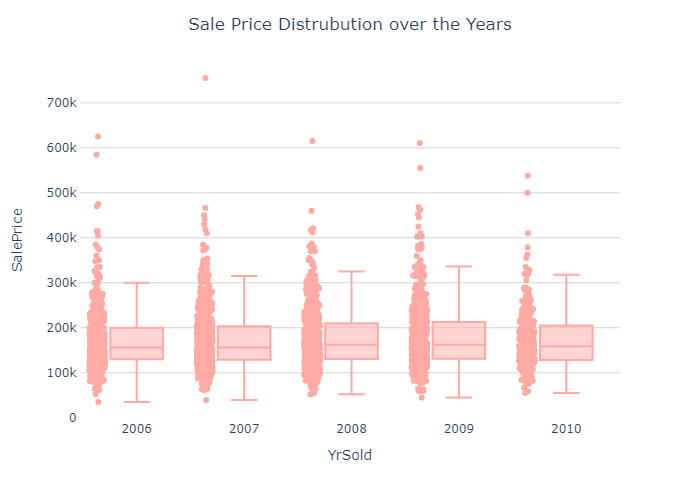

In [6]:
# Sale Price distribution for each year
fig = px.box(
            df, 
            x='YrSold', 
            y="SalePrice", 
            points="all")

fig.update_traces(marker_color = '#ffaaa5')

fig.update_layout(title='Sale Price Distrubution over the Years', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray')

# Add lag terms

In [7]:
# Save 2010 data for predicting
print(df.YrSold.value_counts(normalize=True))

# We'll perform EDA only on the training set so the test set can give us an unbiased estimate of the error. 
df_2010 = df[df['YrSold']==2010].reset_index(drop=True)
df = df[df['YrSold']<2010].reset_index(drop=True)

2009    0.232791
2007    0.230288
2008    0.219858
2006    0.191489
2010    0.125574
Name: YrSold, dtype: float64


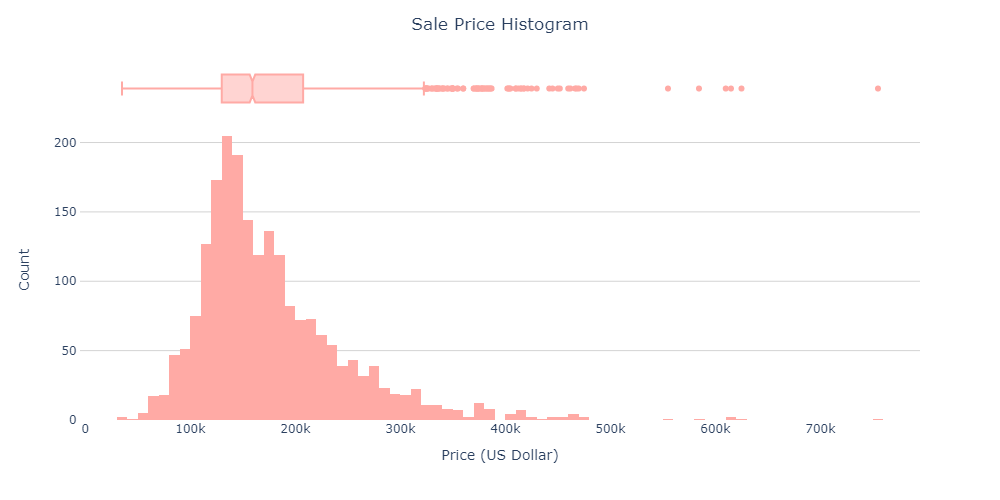

In [8]:
# We plot the target variable

fig = px.histogram(
                df, 
                x="SalePrice",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#ffaaa5')

fig.update_layout(
                title='Sale Price Histogram', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Price (US Dollar)",
                row=1, col=1)

fig.show()

## Missing data

In [9]:
# Check for missing values
missing_data_df(df)

,Count,Percent
PoolQC,2087,99.570611
MiscFeature,2021,96.421756
Alley,1960,93.511450
Fence,1663,79.341603
FireplaceQu,988,47.137405
LotFrontage,403,19.227099
GarageFinish,93,4.437023
GarageYrBlt,93,4.437023
GarageQual,93,4.437023
GarageCond,93,4.437023


In [10]:
# We will drop the PoolQC and PoolArea features since more that 99% of houses don't have a pool.
df.drop(columns=['PoolQC', 'PoolArea'], inplace=True)

### Imputing null values

In [11]:
# LotFrontage

temp = df[~df['LotFrontage'].isna()]

print(temp.LotFrontage.describe())
temp.groupby(['LotConfig']).agg({'LotFrontage':['median', 'count']}).sort_values(by=('LotFrontage', 'median'))


count    1693.000000
mean       68.177200
std        22.676062
min        21.000000
25%        57.000000
50%        67.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64


LotFrontage      
               median count
LotConfig                  
CulDSac          47.5    60
FR2              60.0    44
FR3              62.0     9
Inside           65.0  1314
Corner           80.0   266

We have different types of null values:
- On numerical variables where N/A means no feature we will impute with 0.
- On categorical variables where N/A means no feature we will impute with 'None'.
- The remaining features with N/A values will be imputed as followed:
    - For GarageYrBlt we'll useh YearBuilt.
    - For Electrical we'll use the mode.
    - For MasVnrType we'll impute with 'None'.
    - For MasVnrArea we'll impute with 0.
    - For LotFrontage we'll impute with the median given the LotConfig variable.

In [12]:
df = impute_null(df)
df_2010 = impute_null(df_2010)

## EDA

##### Numerical Features:

`['SalePrice', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                      'BsmtFinSF2', 'BsmtUnfSF',  'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                      'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']`

##### Discrete Features:

`['YearBuilt', 'YearRemodAdd', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
                     'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                     'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'MSSubClass']`

##### Nominal Features:

`['MSZoning', 'Street', 'LandContour', 'LotConfig', 'Neighborhood', 
                    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 
                    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 
                    'GarageType', 'SaleType']`

##### Ordinal Features:

`['LotShape', 'Utilities', 'LandSlope','ExterQual', 'ExterCond', 'BsmtQual', 
                    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
                    'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 
                    'GarageQual', 'GarageCond', 'PavedDrive', 'OverallQual', 'OverallCond']`

#### Sale Price vs. Gross Living Area
- This plot shows that, on average, newer houses have a higher sales price
- The year when a house is built doesn't impact the gross living area. However, homes built before 1900 have a wider range of sizes than those built in the following years. 
    - The average house built after the 2000s hovers around 1600 sqft.
    - The average house built between 1940 and 1979 hovers around 1200 sqft.

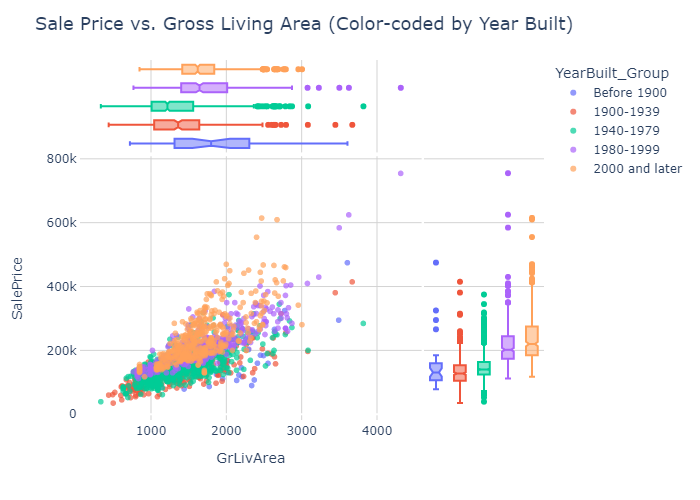

In [13]:
# Create the bins for 'YearBuilt'
bins = [min(df['YearBuilt']), 1900, 1940, 1980, 2000, max(df['YearBuilt'])]

# Create custom labels based on the years in each group
labels = ['Before 1900', '1900-1939', '1940-1979', '1980-1999', '2000 and later']

# Create the 'YearBuilt_Group' column with custom labels for 'YearBuilt' groups
df['YearBuilt_Group'] = pd.cut(df['YearBuilt'], bins=bins, labels=labels)

fig = px.scatter(data_frame=df, x='GrLivArea', y='SalePrice', 
           color='YearBuilt_Group', 
           color_discrete_sequence=px.colors.qualitative.Plotly,
           opacity=0.7,
           category_orders= {'YearBuilt_Group': labels},
           marginal_x='box',
           marginal_y='box')

fig.update_layout(
    title='Sale Price vs. Gross Living Area (Color-coded by Year Built)',
    title_font=dict(size=18),  # Increase the title font size to 24
    plot_bgcolor='white'
)

fig.update_xaxes(showline=True, gridcolor='lightgray')
fig.update_yaxes(showline=True, gridcolor='lightgray')

fig.show()
df['YearBuilt_Group']=df['YearBuilt_Group'].cat.add_categories(0) #to fix modify_features function df = df.fillna(0)


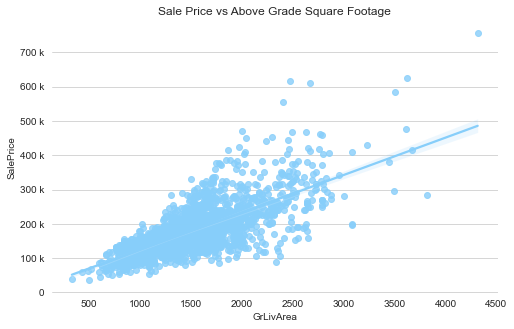

In [14]:
fig, ax = plt.subplots(figsize=(8,5))
sns.despine(left=True, bottom=True)

sns.regplot(x="GrLivArea", y="SalePrice", data=df, ax=ax, color='#87CEFA') 
ax.set_title('Sale Price vs Above Grade Square Footage')
ax.xaxis.grid(False)

ax.yaxis.set_major_formatter(ticker.EngFormatter())

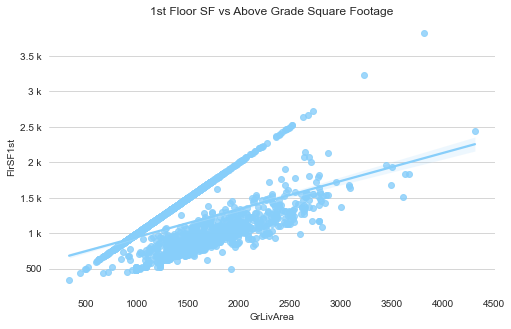

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
sns.despine(left=True, bottom=True)

sns.regplot(x="GrLivArea", y="FlrSF1st", data=df, ax=ax, color='#87CEFA') 
ax.set_title('1st Floor SF vs Above Grade Square Footage')
ax.xaxis.grid(False)

ax.yaxis.set_major_formatter(ticker.EngFormatter())

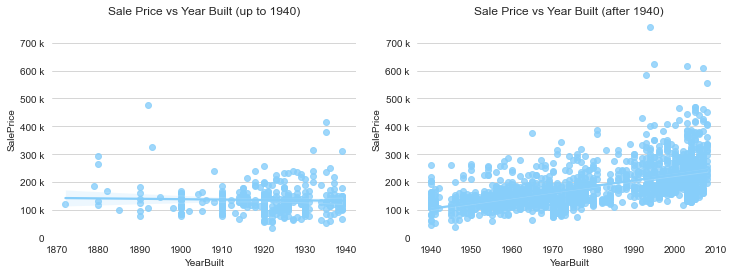

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)
YrCut=1940

sns.regplot(x="YearBuilt", y="SalePrice", data=df[df['YearBuilt']<YrCut], ax=ax[0], color='#87CEFA') 

sns.regplot(x="YearBuilt", y="SalePrice", data=df[df['YearBuilt']>=YrCut], ax=ax[1], color='#87CEFA') 

ax[0].set_title('Sale Price vs Year Built (up to 1940)')
ax[0].xaxis.grid(False)
ax[0].set_ylim(0,780000)
ax[0].yaxis.set_major_formatter(ticker.EngFormatter())

ax[1].set_title('Sale Price vs Year Built (after 1940)')
ax[1].xaxis.grid(False)
ax[1].set_ylim(0,780000)
ax[1].yaxis.set_major_formatter(ticker.EngFormatter())

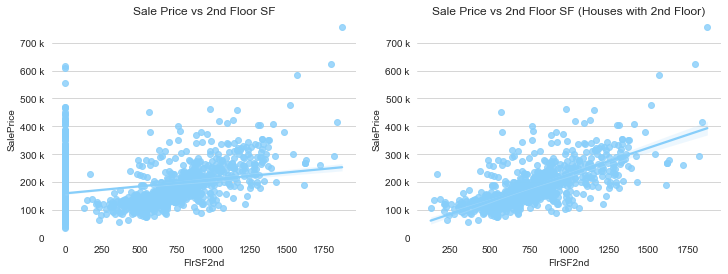

In [17]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

sns.regplot(x="FlrSF2nd", y="SalePrice", data=df, ax=ax[0], color='#87CEFA') 

sns.regplot(x="FlrSF2nd", y="SalePrice", data=df[df['FlrSF2nd']>0], ax=ax[1], color='#87CEFA') 

ax[0].set_title('Sale Price vs 2nd Floor SF')
ax[0].xaxis.grid(False)
ax[0].set_ylim(0,780000)
ax[0].yaxis.set_major_formatter(ticker.EngFormatter())

ax[1].set_title('Sale Price vs 2nd Floor SF (Houses with 2nd Floor)')
ax[1].xaxis.grid(False)
ax[1].set_ylim(0,780000)
ax[1].yaxis.set_major_formatter(ticker.EngFormatter())

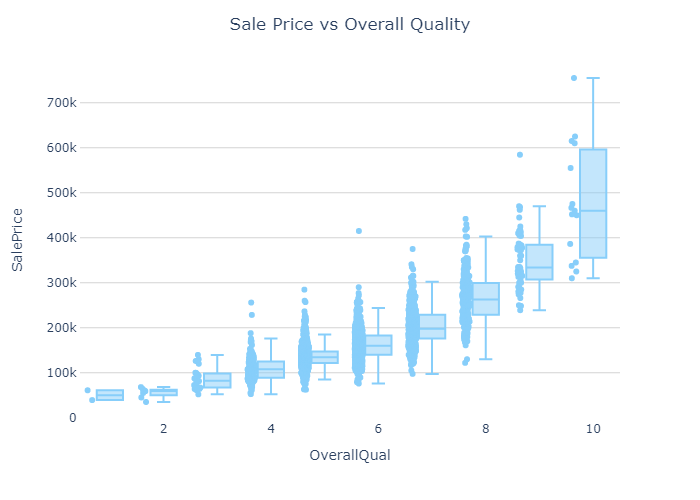

In [18]:
order = df.groupby('OverallQual').SalePrice.median().sort_values().index

fig = px.box(
            df, 
            x='OverallQual', 
            y="SalePrice", 
            points="all",
            category_orders={'OverallQual':order})

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs Overall Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray')

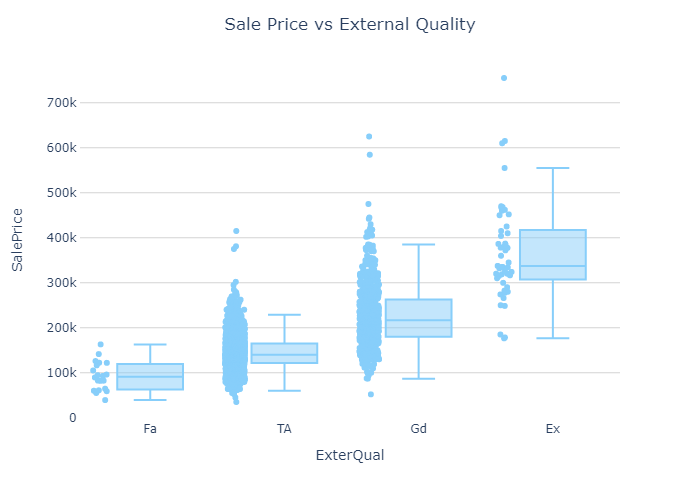

In [19]:
order = df.groupby('ExterQual').SalePrice.median().sort_values().index

fig = px.box(
            df, 
            x='ExterQual', 
            y="SalePrice", 
            points="all",
            category_orders={'ExterQual':order})

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs External Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray')

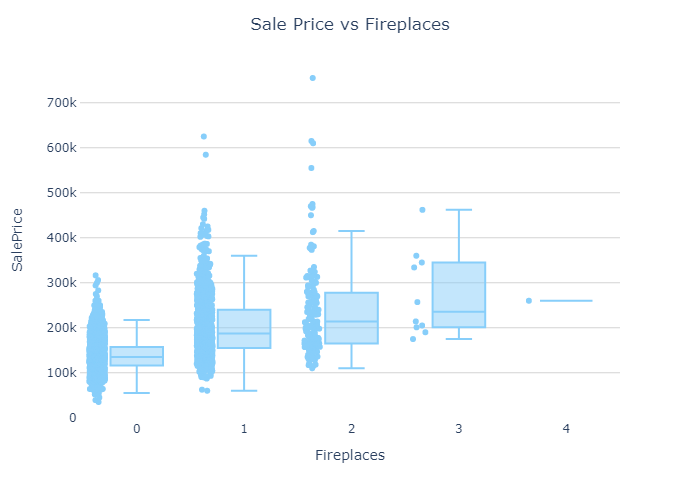

In [20]:
fig = px.box(
            df, 
            x='Fireplaces', 
            y="SalePrice", 
            points="all")

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs Fireplaces', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray')

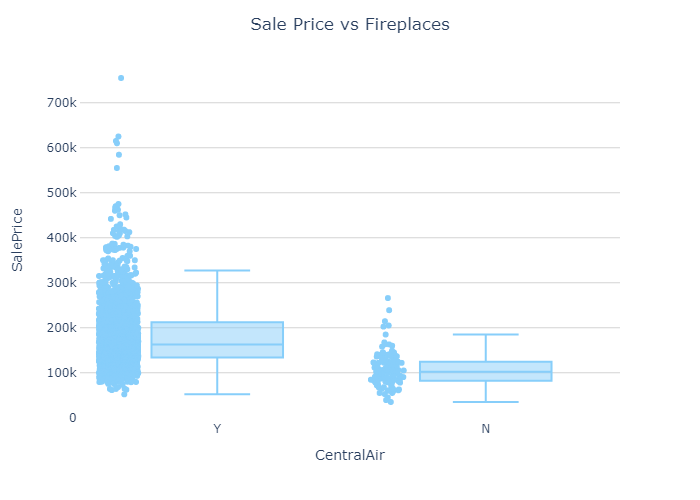

In [21]:
fig = px.box(
            df, 
            x='CentralAir', 
            y="SalePrice", 
            points="all")

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs Fireplaces', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray')

## Feature Engineering

In [22]:
# Create HouseAge and RemodAge feature.
# Merge underpopulated categories
# Binarize features where only a few categories appear to be correlated to SalesPrice.
# Create a Location features
df = modify_features(df)
df_2010 = modify_features(df_2010)

In [23]:
# Encode ordinal features into numbers. 
df = encode_ordinal(df)
df_2010 = encode_ordinal(df_2010)

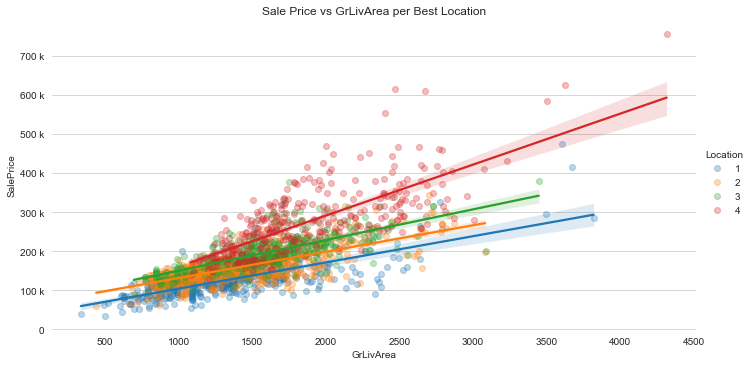

In [24]:
g = sns.lmplot(
            x="GrLivArea", 
            y="SalePrice", 
            data=df, 
            hue='Location', 
            aspect=2,
            scatter_kws={'alpha':0.3}) 

sns.despine(left=True, bottom=True)
ax = g.axes[0,0]
ax.set_title('Sale Price vs GrLivArea per Best Location')
ax.xaxis.grid(False)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

In [25]:
# Dummies Location and BldgType features
df = dummify_features(df)
df_2010 = dummify_features(df_2010)


### Check for interaction terms

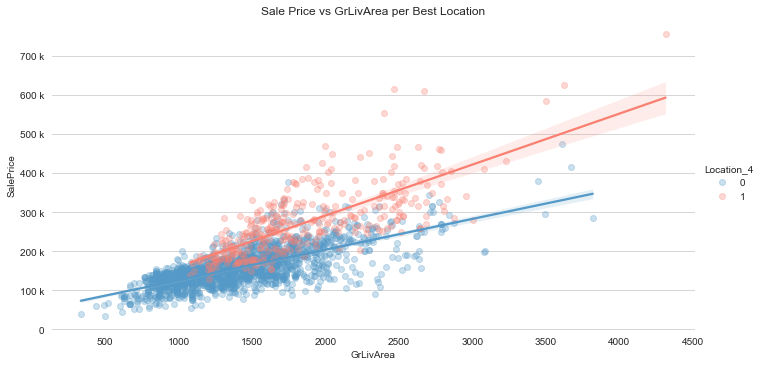

In [26]:
palette = {
    '#FA8072',
    '#5499C7'
}

g = sns.lmplot(
            x="GrLivArea", 
            y="SalePrice", 
            data=df, 
            hue='Location_4', 
            aspect=2,
            scatter_kws={'alpha':0.3},
            palette=palette) 

sns.despine(left=True, bottom=True)
ax = g.axes[0,0]
ax.set_title('Sale Price vs GrLivArea per Best Location')
ax.xaxis.grid(False)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

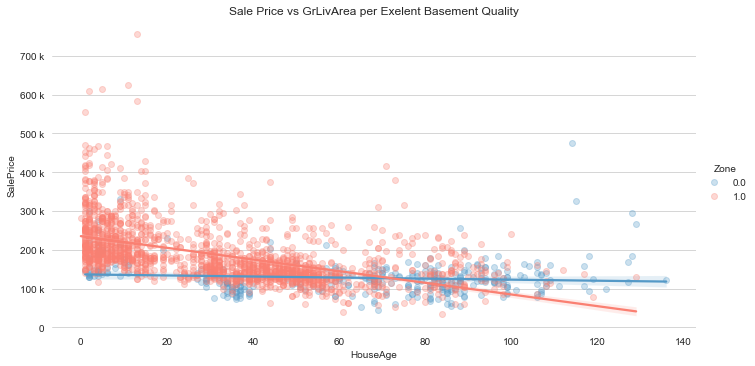

In [27]:
g = sns.lmplot(
            x="HouseAge", 
            y="SalePrice", 
            data=df, 
            hue='Zone', 
            aspect=2, 
            scatter_kws={'alpha':0.3},
            palette=palette) 

sns.despine(left=True, bottom=True)
ax = g.axes[0,0]
ax.set_title('Sale Price vs GrLivArea per Exelent Basement Quality')
ax.xaxis.grid(False)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

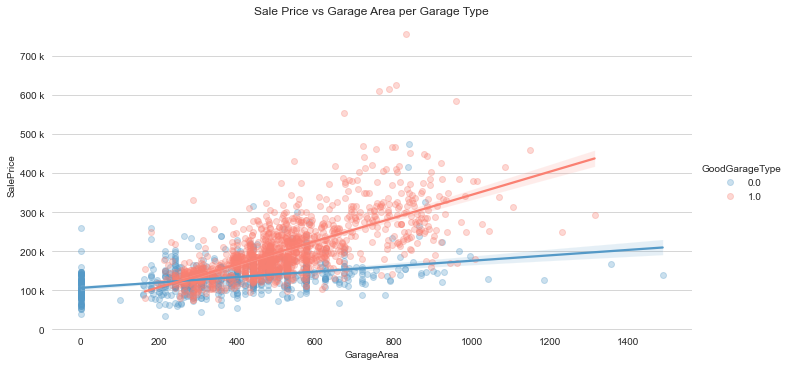

In [28]:
g = sns.lmplot(
            x="GarageArea", 
            y="SalePrice", 
            data=df, 
            hue='GoodGarageType', 
            aspect=2, 
            scatter_kws={'alpha':0.3},
            palette=palette) 

sns.despine(left=True, bottom=True)
ax = g.axes[0,0]
ax.set_title('Sale Price vs Garage Area per Garage Type')
ax.xaxis.grid(False)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

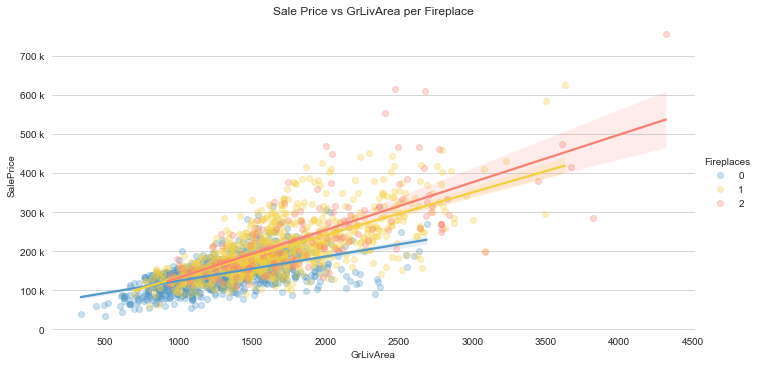

In [29]:
palette = {
    '#FA8072',
    '#5499C7',
    '#F4D03F'
}

g = sns.lmplot(
            x="GrLivArea", 
            y="SalePrice", 
            data=df, 
            hue='Fireplaces', 
            aspect=2,
            scatter_kws={'alpha':0.3},
            palette=palette) 

sns.despine(left=True, bottom=True)
ax = g.axes[0,0]
ax.set_title('Sale Price vs GrLivArea per Fireplace')
ax.xaxis.grid(False)
ax.yaxis.set_major_formatter(ticker.EngFormatter())

# Feature Correlation

In [30]:
feature_selection = ['ExterQual', 'BsmtQual', 'KitchenQual', 'OverallQual', 
                    'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'FullBath', 
                    'HouseAge', 'TotRmsAbvGrd', 'OverallCond',  'FlrSF1st', 'FlrSF2nd',
                    'Fireplaces', 'LotFrontage', 'LotArea', 'MSSubClass', 'GoodGarageType', 
                    'BsmtUnfSF', 'Zone', 'Location_2', 'Location_3', 'Location_4',
                    'CulDSac', 'Exterior1st_top', 'ExQual', 'RemodAge', 'LargerHouse', 'Remod', 
                    'ExBsmtQual', 'TwoStory', 'TotalSF', 'RoadRail', 'ExKitchen', 'CentralAir',
                    'TotalBath']

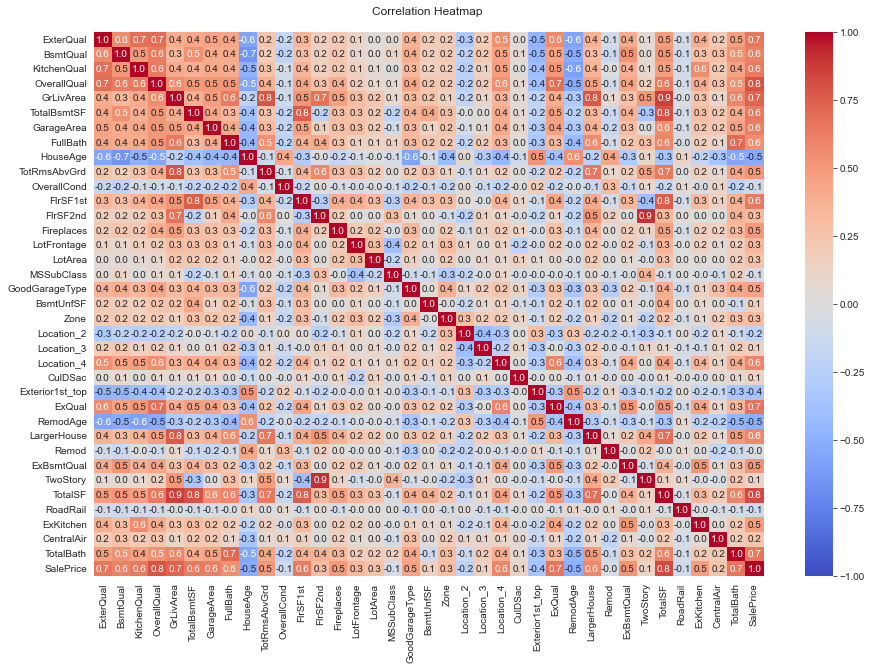

In [31]:
plt.figure(figsize=(15, 10))

corr_mat = df[feature_selection + ['SalePrice']].corr()

sns.heatmap(corr_mat,
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1,
            cmap='coolwarm'
            )
title = plt.title('Correlation Heatmap \n')

### Searching for non-linear and non-constant variance features

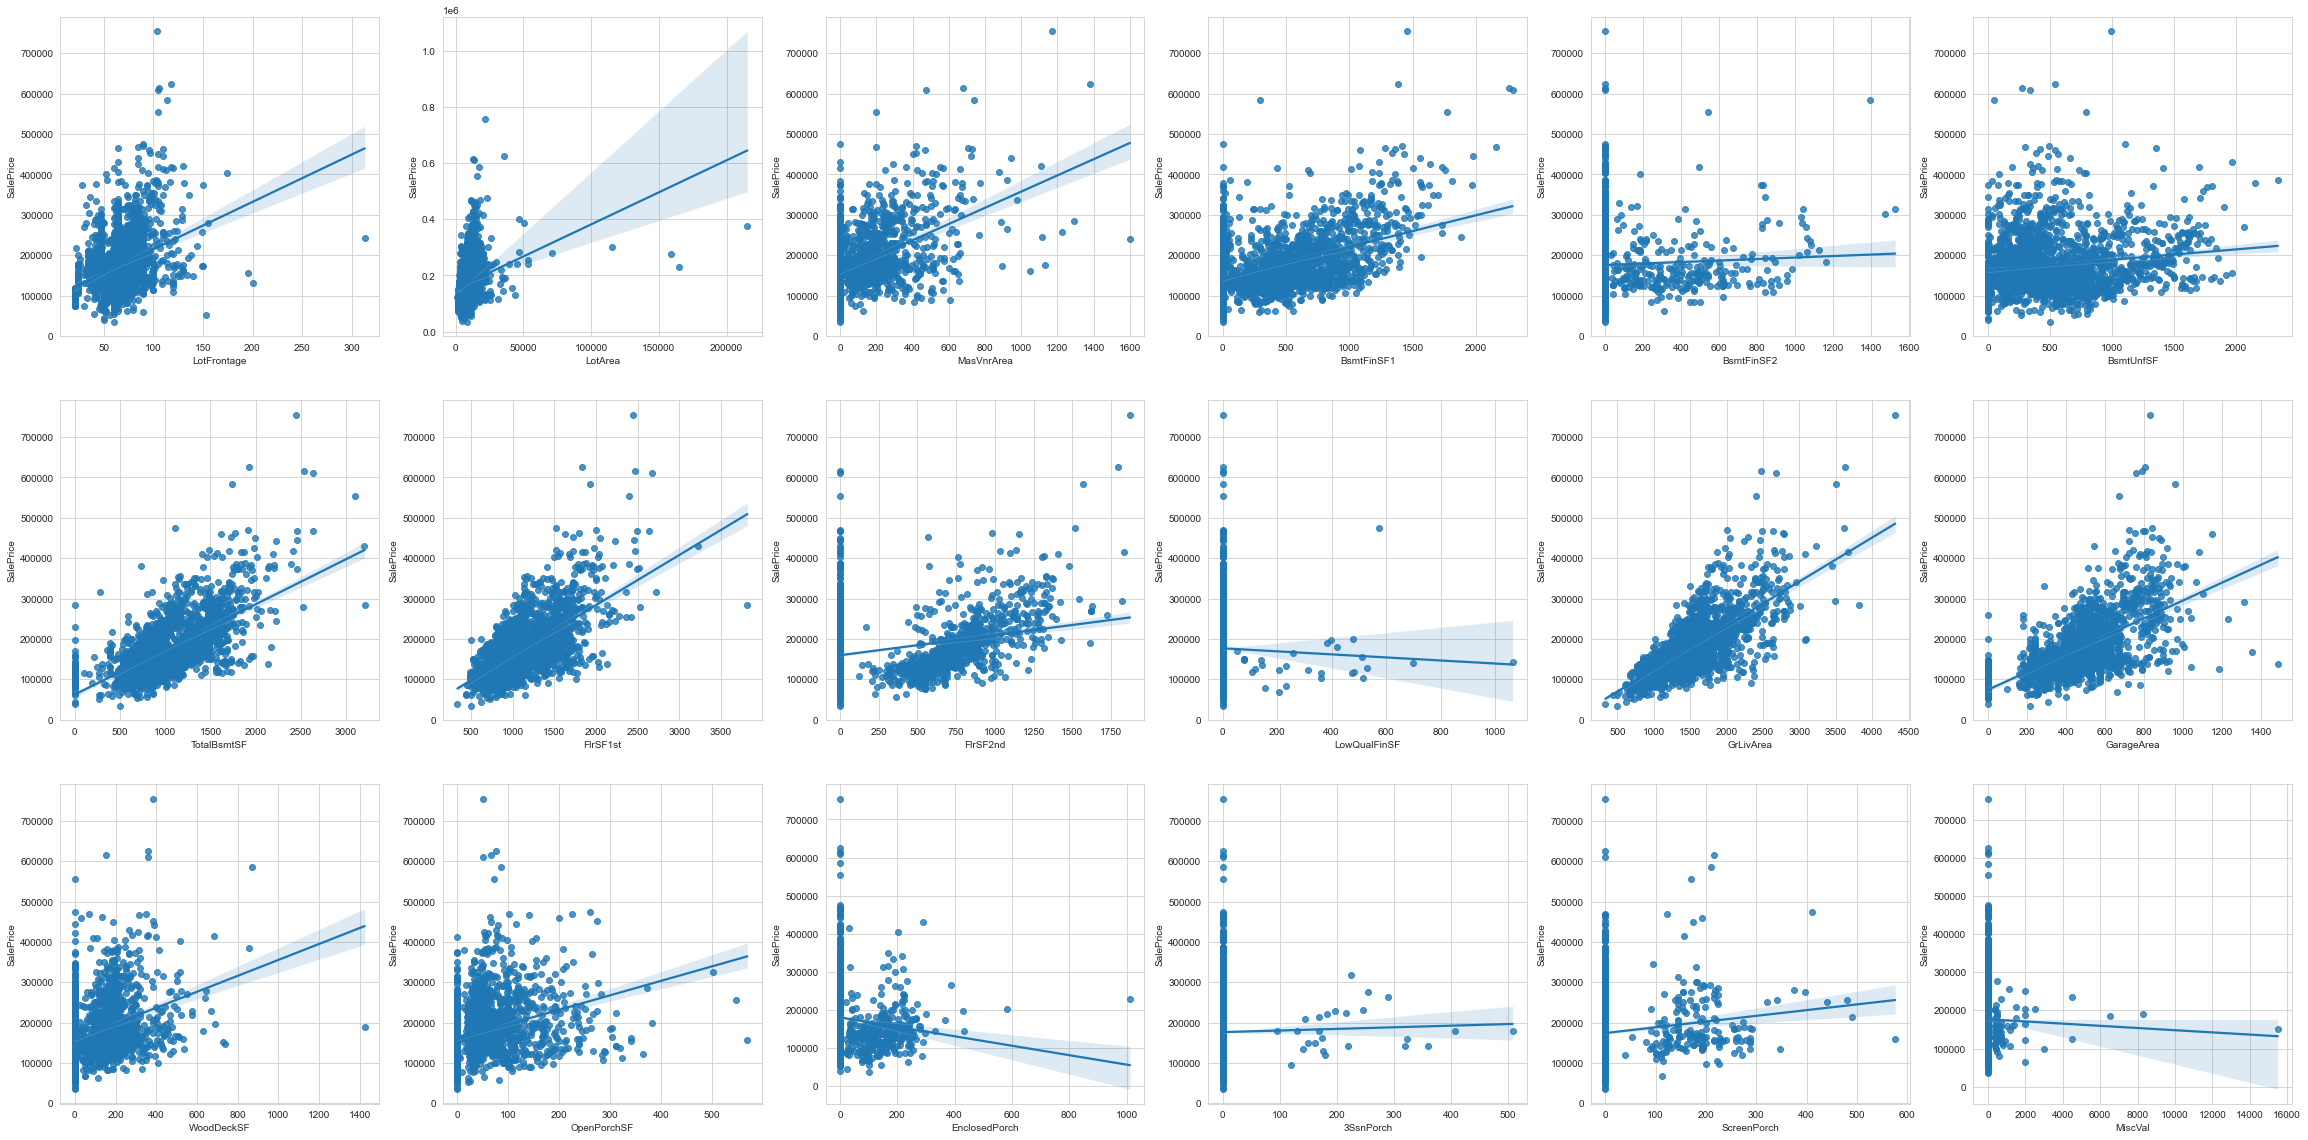

In [52]:
numerical_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 
                      'BsmtFinSF2', 'BsmtUnfSF',  'TotalBsmtSF', 'FlrSF1st', 'FlrSF2nd', 
                      'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
                      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal']

fig, axs = plt.subplots(3,6, figsize=(40,20))
#plt.figure(figsize=(15, 10))
for i, feat in enumerate(numerical_features):
    #axs[int(i/6),int(i%6)].scatter(x = df[feat], y= df['SalePrice'])
    sns.regplot(data = df, x = feat, y='SalePrice', ax = axs[int(i/6),int(i%6)])

### Potentially non-constant variance features by inspection:

`['MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', 'FlrSF1st', 'FlrSF2nd', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch', 'ScreenPorch']`

Notably, these are all area features.

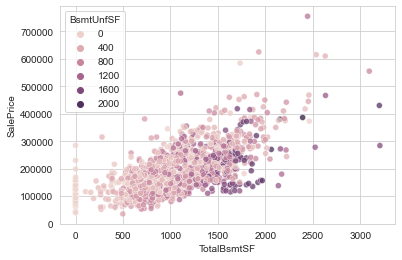

In [38]:
g = sns.scatterplot(
            x="TotalBsmtSF", 
            y="SalePrice", 
            data=df, 
            hue='BsmtUnfSF',
            alpha = 0.75) 

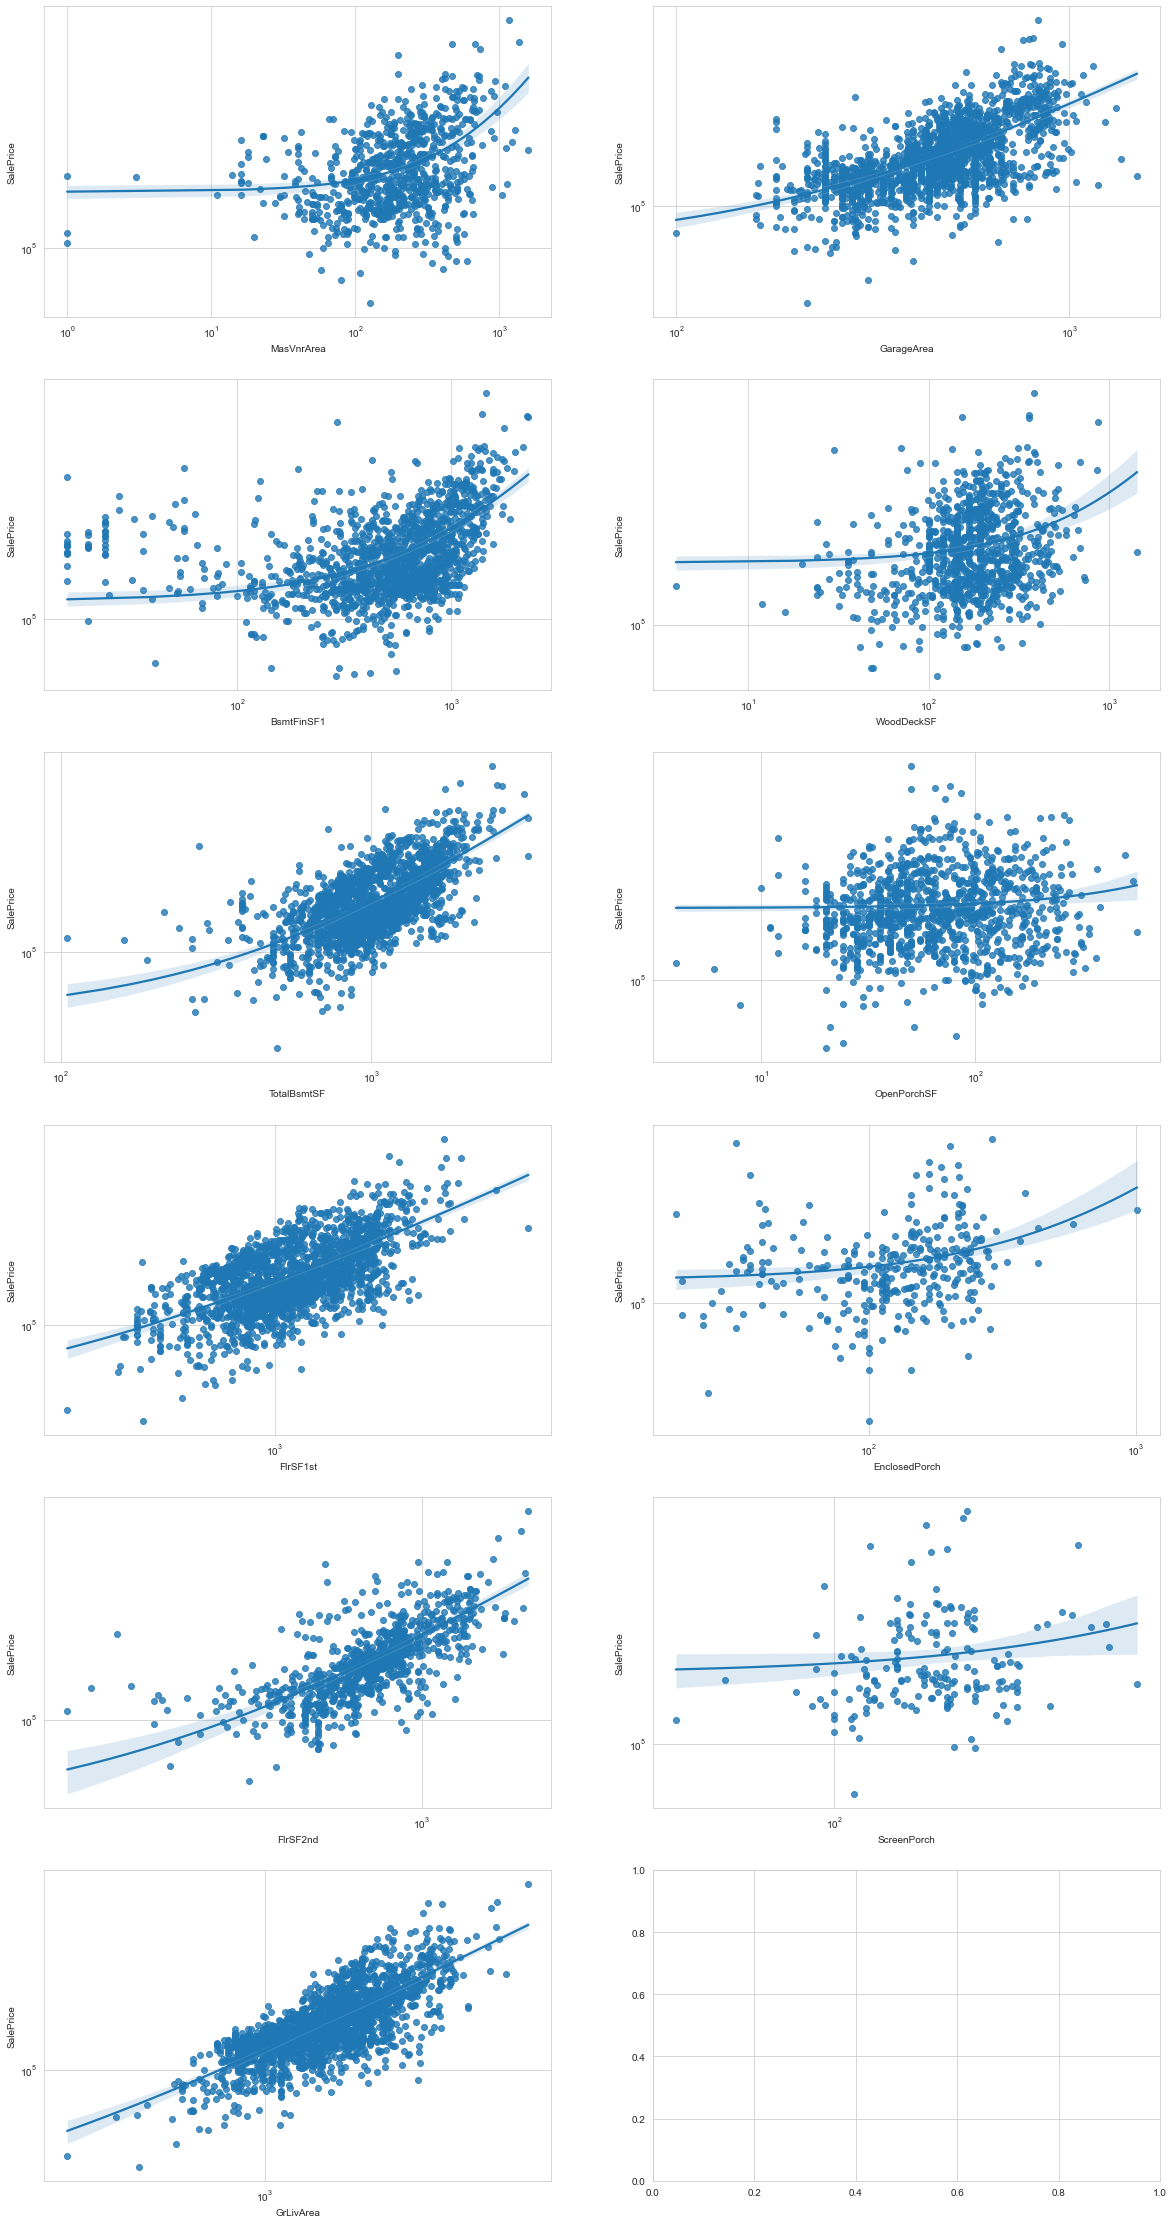

In [69]:
log_features = ['MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', 'FlrSF1st', 'FlrSF2nd', 'GrLivArea', 
                'GarageArea', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch', 'ScreenPorch']

fig, axs = plt.subplots(6,2, figsize=(20,40))
 
for i, feat in enumerate(log_features):
    df_nonzero = df[df[feat]>0]
    sns.regplot(data = df_nonzero, x = feat, y='SalePrice', ax = axs[int(i%6),int(i/6)])
    axs[int(i%6),int(i/6)].set_xscale('log')
    axs[int(i%6),int(i/6)].set_yscale('log')


Viewing this way, we find a strong log relationship in the following features:

`['TotalBsmtSF', 'FlrSF1st', 'FlrSF2nd', 'GrLivArea', 'GarageArea']`